Emotion detection

In [2]:
# full code for implementing a ResNet-like architecture from scratch for image classification 
# on the FER2013 dataset, including data preprocessing and model evaluation
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
# Define directory paths for training and testing data
train_dir = "../input/fer2013/train"
test_dir = "../input/fer2013/test"
img_size = 48

In [4]:
# Data augmentation and preprocess data
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [5]:
# Generate batches of tensor image data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
# Define a function for a ResNet identity block
def identity_block(input_tensor, kernel_size, filters):
    filters1, filters2 = filters
    
    x = Conv2D(filters1, (1, 1), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters1, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, (1, 1))(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [7]:
# Define a function for a ResNet convolutional block
def convolutional_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    filters1, filters2 = filters
    
    x = Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters1, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, (1, 1))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(filters2, (1, 1), strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [8]:
# Define the input
input_img = Input(shape=(img_size, img_size, 1))

# First layer
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)

# Residual blocks
x = convolutional_block(x, 3, [64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 256])
x = identity_block(x, 3, [64, 256])

# Classifier
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

In [9]:
# Create model
model = Model(inputs=input_img, outputs=output)

In [10]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Train the model
history = model.fit(
    x=train_generator,
    epochs=60,
    validation_data=validation_generator
)

Epoch 1/60
359/359 [==============================] - 251s 689ms/step - loss: 1.7958 - accuracy: 0.2591 - val_loss: 3.9478 - val_accuracy: 0.2472
Epoch 2/60
359/359 [==============================] - 238s 663ms/step - loss: 1.6297 - accuracy: 0.3465 - val_loss: 2.0193 - val_accuracy: 0.2856
Epoch 3/60
359/359 [==============================] - 238s 662ms/step - loss: 1.4988 - accuracy: 0.4157 - val_loss: 2.2554 - val_accuracy: 0.2933
Epoch 4/60
359/359 [==============================] - 235s 654ms/step - loss: 1.4044 - accuracy: 0.4576 - val_loss: 2.1233 - val_accuracy: 0.2549
Epoch 5/60
359/359 [==============================] - 235s 655ms/step - loss: 1.3373 - accuracy: 0.4900 - val_loss: 1.5779 - val_accuracy: 0.4043
Epoch 6/60
359/359 [==============================] - 236s 657ms/step - loss: 1.2786 - accuracy: 0.5131 - val_loss: 1.3339 - val_accuracy: 0.4742
Epoch 7/60
359/359 [==============================] - 236s 657ms/step - loss: 1.2373 - accuracy: 0.5299 - val_loss: 1.3207 -

In [12]:
# Evaluate the model
test_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = test_generator.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

test_loss, test_accuracy = model.evaluate(test_data_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 30s 265ms/step - loss: 1.3125 - accuracy: 0.5768
Test loss: 1.3125454187393188
Test accuracy: 0.576762318611145


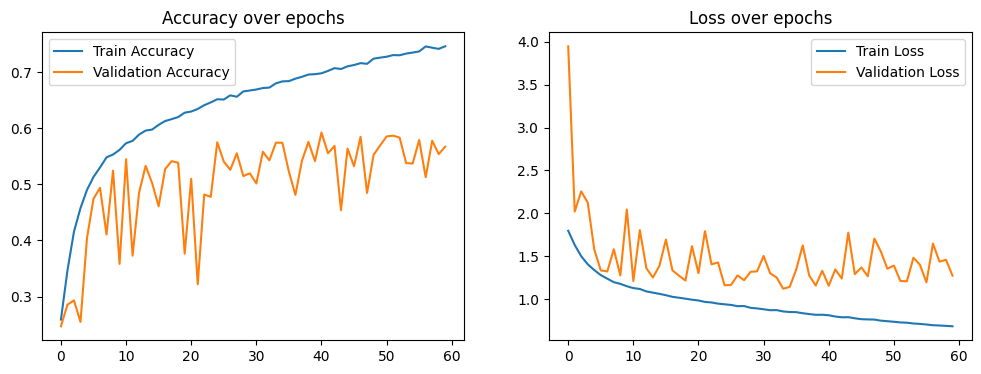

In [23]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.show()

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 20s 180ms/step


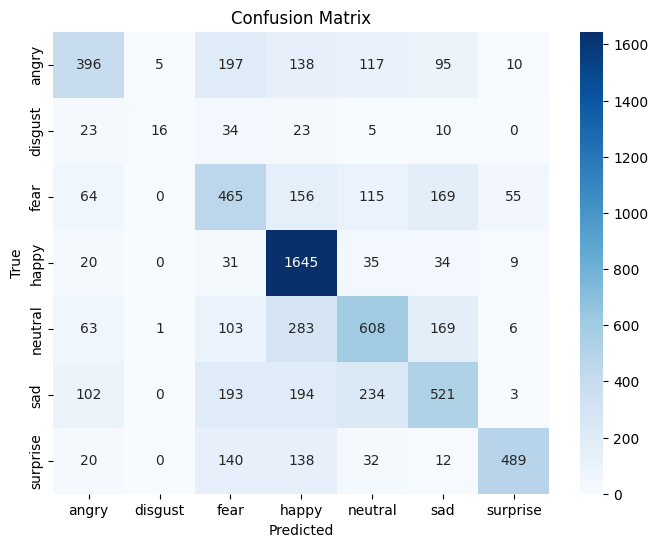

In [29]:
# Confusion matrix
# Generate batches of tensor image data for testing
test_prediction_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode=None,  # Set to None for predictions
    shuffle=False      # Do not shuffle for confusion matrix
)

# Generate predictions on the test set
y_pred = model.predict(test_prediction_generator, verbose=1)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = test_prediction_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [15]:
# Model export 
model.save('ResNet.keras')
print("ResNet.keras")


ResNet.keras
